In [2]:
"""
@author Dakota Rawlings
@email dakota@mrl.ucsb.edu

This ipynb file describes the feature engineering and model building for the trulia realestate dataset
""";

#general tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3

#data processing tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
from scipy import stats
import shap
from sklearn.neighbors import KNeighborsRegressor

#model building tools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool
import statsmodels.api as sm

#model productionalization tools
import pickle


## Import and format data

In [3]:
#Establish connection with the local trulia housing .db SQLite file
conn = sqlite3.connect(r'trulia_sb_house_data.db')

#read the "cleaned data" table from the trulia housing database and store in a pandas dataframe
df = pd.read_sql_query("SELECT * FROM trulia_house_SB_data_cleaned", conn)

In [4]:
#general summary information for the dataframe:
df.head()
df.columns

Index(['level_0', 'index', 'price', 'address', 'zip', 'num_bedrooms',
       'num_baths', 'building_sqft', 'year_built', 'lot_area',
       'home_description', 'feature_list', 'house_age', 'has_garage',
       'has_fireplace', 'has_ocean_views', 'has_mountain_views',
       'has_hope_ranch', 'has_montecito', 'has_pool', 'has_upstairs', 'has_IV',
       'building_sqft_was_missing'],
      dtype='object')

In [5]:
df.describe()

,level_0,index,price,num_bedrooms,num_baths,building_sqft,year_built,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,has_mountain_views,has_hope_ranch,has_montecito,has_pool,has_upstairs,has_IV,building_sqft_was_missing
count,906.000000,906.000000,906.000000,906.000000,906.000000,750.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,633.844371,633.844371,2.697768,3.615894,3.197351,2.563863,1966.833333,0.837355,55.166667,0.390728,0.417219,0.112583,0.185430,0.045254,0.160044,0.239514,0.120309,0.003311,0.172185
std,374.363060,374.363060,1.902631,0.977273,1.391273,1.409905,24.700680,1.570894,24.700680,0.488183,0.493372,0.316257,0.388861,0.207975,0.366850,0.427023,0.325502,0.057480,0.377750
min,0.000000,0.000000,0.009500,2.000000,1.500000,0.668000,1900.000000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,307.250000,307.250000,1.360318,3.000000,2.000000,1.564000,1956.000000,0.170000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,623.000000,623.000000,1.980500,4.000000,3.000000,2.189500,1963.000000,0.260000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,957.750000,957.750000,3.490750,4.000000,4.000000,3.043750,1985.000000,1.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1296.000000,1296.000000,9.910000,9.000000,11.000000,10.823000,2021.000000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#drop features that are not useful for the model
df_model=df.drop(['level_0','index', 'address', 'year_built', 'home_description', 'feature_list'],axis=1)

## Feature Engineering

### One hot encoding

In [7]:
#The only catagorical feature is the zipcode. Use one hot encoding to create dummy variables for zip code categories
enc=OneHotEncoder(handle_unknown='ignore')

enc_df=pd.DataFrame(enc.fit_transform(df[['zip']]).toarray())
enc_df.columns=enc.get_feature_names(['zip'])

df_model=df_model.join(enc_df)
df_model.head()

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,price,zip,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
0,3.900000,93108,3.0,3.0,2.354,1.00,62.0,0,0,0,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.780000,93105,3.0,2.0,1.395,0.14,73.0,1,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.350000,93105,3.0,2.0,1.344,0.50,50.0,0,1,0,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.899000,93109,3.0,3.0,2.558,0.50,42.0,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.824215,93109,4.0,2.0,1.407,0.14,63.0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
#Print the number of null values in each column 
print(df_model.isnull().sum())

price                          0
zip                            0
num_bedrooms                   0
num_baths                      0
building_sqft                156
lot_area                       0
house_age                      0
has_garage                     0
has_fireplace                  0
has_ocean_views                0
has_mountain_views             0
has_hope_ranch                 0
has_montecito                  0
has_pool                       0
has_upstairs                   0
has_IV                         0
building_sqft_was_missing      0
zip_93067                      0
zip_93101                      0
zip_93103                      0
zip_93105                      0
zip_93108                      0
zip_93109                      0
zip_93110                      0
zip_93111                      0
zip_93117                      0
dtype: int64


### Imputation

In [9]:
#Here we perform some imputation to approximate and fill in any nan values

def knn_imputer(df):
    #This function takes in a dataframe and imputes missing numeric values with a knn regressor

    #isolate the columns with categorical data
    cat_data=df.select_dtypes(exclude=[np.number])
    
    #isolate the columns with numeric data
    numeric_data=df.select_dtypes(include=[np.number])

    nan_columns=numeric_data.columns[numeric_data.isna().any()].tolist()

    no_nan_columns=numeric_data.drop(columns=nan_columns).columns

    for col in nan_columns:

        KNN_test_data=numeric_data[numeric_data[col].isna()]

        KNN_train_data=numeric_data.dropna()

        KNN_model=KNeighborsRegressor(n_neighbors=3)

        KNN_model.fit(KNN_train_data[no_nan_columns], KNN_train_data[col])

        numeric_data.loc[numeric_data[col].isna(),col]=KNN_model.predict(KNN_test_data[no_nan_columns])

    return pd.concat([numeric_data, cat_data], axis=1)

#df_model=knn_imputer(df_model)
df_model.dropna(subset=['building_sqft'], inplace=True)

In [10]:
#Print the number of null values in each column to ensure that no columns have null values
print(df_model.isnull().sum())

price                        0
zip                          0
num_bedrooms                 0
num_baths                    0
building_sqft                0
lot_area                     0
house_age                    0
has_garage                   0
has_fireplace                0
has_ocean_views              0
has_mountain_views           0
has_hope_ranch               0
has_montecito                0
has_pool                     0
has_upstairs                 0
has_IV                       0
building_sqft_was_missing    0
zip_93067                    0
zip_93101                    0
zip_93103                    0
zip_93105                    0
zip_93108                    0
zip_93109                    0
zip_93110                    0
zip_93111                    0
zip_93117                    0
dtype: int64


In [11]:
#Final descriptive statistics for each numeric column in the dataframe
df_model.describe()

,price,num_bedrooms,num_baths,building_sqft,lot_area,house_age,has_garage,has_fireplace,has_ocean_views,has_mountain_views,...,building_sqft_was_missing,zip_93067,zip_93101,zip_93103,zip_93105,zip_93108,zip_93109,zip_93110,zip_93111,zip_93117
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.0,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,2.556597,3.609333,3.133333,2.563863,0.724675,54.900000,0.417333,0.456000,0.118667,0.200000,...,0.0,0.001333,0.061333,0.105333,0.192000,0.189333,0.084000,0.113333,0.110667,0.142667
std,1.790440,0.955998,1.356715,1.409905,1.401334,23.990917,0.493448,0.498393,0.323612,0.400267,...,0.0,0.036515,0.240101,0.307187,0.394136,0.392035,0.277573,0.317211,0.313928,0.349966
min,0.437500,2.000000,2.000000,0.668000,0.000002,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.335000,3.000000,2.000000,1.564000,0.169995,38.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.860250,4.000000,3.000000,2.189500,0.230002,59.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.047500,4.000000,4.000000,3.043750,0.800000,66.000000,1.000000,1.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.815000,9.000000,11.000000,10.823000,15.000000,122.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PCA and clustering analysis

In [12]:
PCA_cols=['num_bedrooms',
       'num_baths', 'building_sqft', 'lot_area',
        'house_age', 'has_garage',
       'has_fireplace', 'has_ocean_views', 'has_mountain_views',
       'has_hope_ranch', 'has_montecito']

PCA_cols=['num_bedrooms',
       'num_baths', 'building_sqft', 'lot_area',]
#
X=df_model[PCA_cols]
#scale our x data
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
from sklearn.decomposition import PCA
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

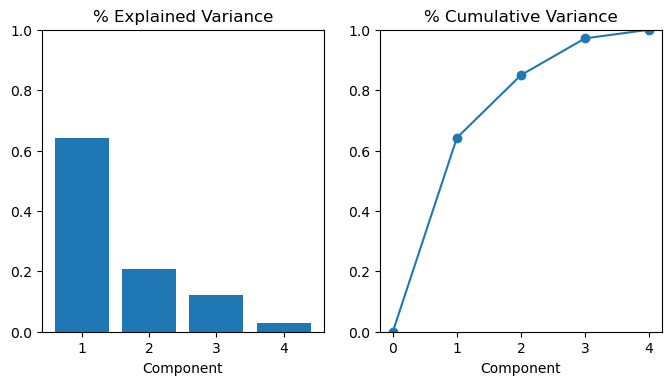

In [13]:
# Look at explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
plot_variance(pca)

In [14]:
X_pca.head()

,PC1,PC2,PC3,PC4
0,-0.369648,0.480644,-0.322315,-0.071577
1,-1.400100,0.055795,0.045284,-0.000138
2,-1.332692,0.284632,0.142644,-0.030401
3,-0.408865,0.157835,-0.498263,0.035860
4,-0.912129,-0.417940,0.837532,0.063493


In [15]:
X.columns

Index(['num_bedrooms', 'num_baths', 'building_sqft', 'lot_area'], dtype='object')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

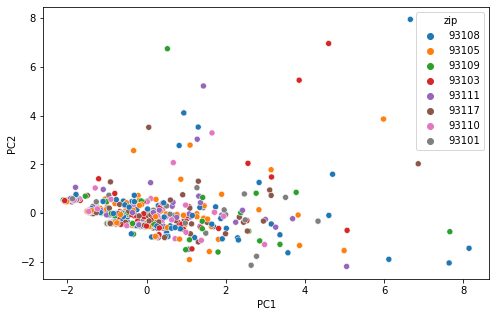

In [17]:
# Create cluster features using kmeans clustering and use as hue when plotting PCA1 vs. PCA2 to visualize clustering in the data
from sklearn.cluster import KMeans
plt.figure(figsize=(8, 5))
kmeans = KMeans(n_clusters=3)
X_pca["zip"] = df_model['zip']
sns.scatterplot('PC1','PC2', hue="zip",data=X_pca)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

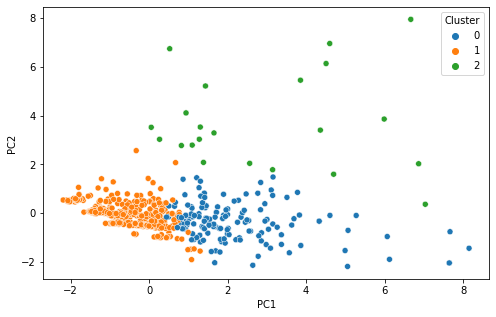

In [18]:
# Create cluster features using kmeans clustering and use as hue when plotting PCA1 vs. PCA2 to visualize clustering in the data
from sklearn.cluster import KMeans
plt.figure(figsize=(8, 5))
kmeans = KMeans(n_clusters=3)
X_pca["Cluster"] = kmeans.fit_predict(X)
X_pca["Cluster"] = X_pca["Cluster"].astype("category")
sns.scatterplot('PC1','PC2', hue="Cluster",data=X_pca)

### Mutual information scores for each feature
* *Conclusions:*
* The building sqft, the lot area, and the location of the lot seem to be the most important features in determining the yield strength. 

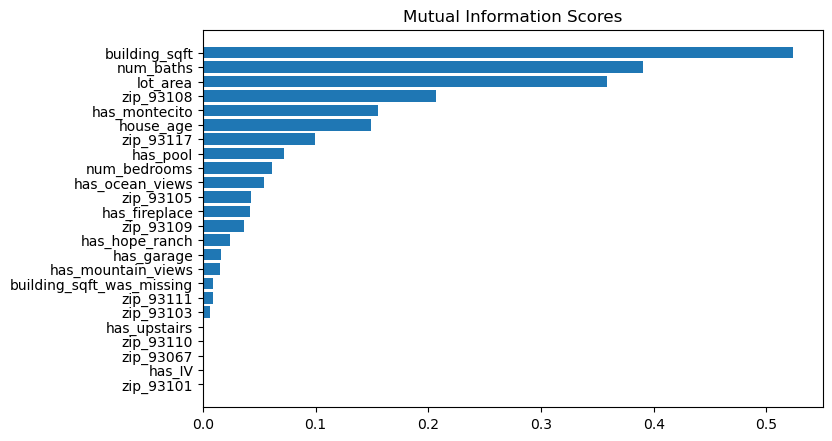

In [19]:


from sklearn.feature_selection import mutual_info_regression

X=df_model.drop(['price','zip'],axis=1)
y=df_model['price']

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
mi_scores[::3]

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Random Forest Feature Importances
* *Conclusions:*
* Looking at RF feature importances, it seems that the building sqft, the house age, and a few location features result in the largest decrease in RSS. The building sqft feature far outways the other features, which is in contrast to the mutual information plot. This might indicate that there is some significant multicolinearity between the top features in the mutual information plot above. 

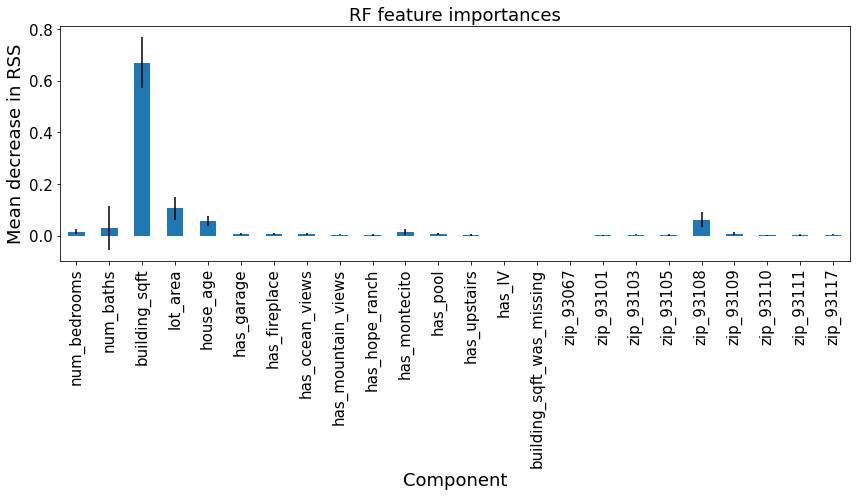

In [20]:
#Fit rnadom forest model to all of the data and plot feature importance values
rf = RandomForestRegressor()
rf.fit(X,y)
import time
import numpy as np
feature_names = [i for i in X.columns]
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize=(12,7))
forest_importances.plot.bar(yerr=std, ax=ax)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Component', fontsize=18)
plt.ylabel("Mean decrease in RSS", fontsize=18)
plt.title("RF feature importances", fontsize=18)
fig.tight_layout()

## Normalization

In [11]:
#normalize the skewed numeric variables
#df_model['num_baths']=np.log1p(df_model['num_baths'])[0]

#df_model['lot_area']=np.log1p(df_model['lot_area'])[0]

#df_model["building_sqft"] = np.log1p(df_model["building_sqft"])

#df_model["house_age"] = np.log1p(df_model["house_age"])

In [12]:
#normalize the target variable

normalized_price_data=np.log1p(df_model['price'])

## Model Building

In [13]:
#Establish X and y. Split data into training and testing set

X=df_model.drop(['price','zip'],axis=1)

y=normalized_price_data
#y=df_model['price']

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)


In [14]:
#define function to find rmse
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [15]:
#define function to find mae
def mae(y, y_pred):
    return np.mean(np.abs(y-y_pred))

In [16]:
#define a function to perform cross validation and firn RMSE for model
def cv_rmse(model):
    return(np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3)))


In [17]:
#Start the model building process by making a few representative models with statsmodels and catboost 
#to visualize the quality of the fit and the relative importance of each feature

#Here we start by using statsmodel multilinear regression api because it makes it easy to view the quality of 
#the linear fit and the P values for each variable 

X_sm=sm.add_constant(X)
model=sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     113.1
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          1.89e-217
Time:                        21:37:19   Log-Likelihood:                 148.24
No. Observations:                 750   AIC:                            -250.5
Df Residuals:                     727   BIC:                            -144.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.6632      0.039     16.990      0.000       0.587       0.740
num_bedrooms                 -0.0344      0.010     -3.372      0.001      -0.054      -0.014
num_baths                     0.0367      0.012      2.993      0.003       0.013       0.061
building_sqft                 0.1560      0.012     12.613      0.000       0.132       0.180
lot_area                      0.0267      0.006      4.421      0.000       0.015       0.039
house_age                     0.0004      0.000      1.057      0.291      -0.000       0.001
has_garage                   -0.0160      0.016     -1.022      0.307      -0.047       0.015
has_fireplace                 0.0014      0.015      0.091      0.927      -0.029       0.032
has_ocean_views              -0.0165      0.025     -0.671      0.502      -0.065       0.032
has_mountain_views            0.0006      0.020      0.031      0.976      -0.038       0.039
has_hope_ranch                0.1797      0.045      4.012      0.000       0.092       0.268
has_montecito                 0.0368      0.033      1.111      0.267      -0.028       0.102
has_pool                      0.0307      0.019      1.585      0.113      -0.007       0.069
has_upstairs                  0.0234      0.022      1.062      0.289      -0.020       0.067
has_IV                       -0.0224      0.119     -0.188      0.851      -0.256       0.211
building_sqft_was_missing  3.647e-17   3.18e-17      1.146      0.252    -2.6e-17    9.89e-17
zip_93067                     0.2462      0.183      1.343      0.180      -0.114       0.606
zip_93101                    -0.0062      0.036     -0.174      0.862      -0.076       0.064
zip_93103                     0.1200      0.030      3.938      0.000       0.060       0.180
zip_93105                     0.0033      0.027      0.122      0.903      -0.049       0.056
zip_93108                     0.3081      0.035      8.720      0.000       0.239       0.377
zip_93109                     0.1975      0.032      6.246      0.000       0.135       0.260
zip_93110                    -0.0002      0.033     -0.005      0.996      -0.065       0.065
zip_93111                    -0.0790      0.030     -2.613      0.009      -0.138      -0.020
zip_93117                    -0.1265      0.029     -4.343      0.000      -0.184      -0.069
==============================================================================
Omnibus:                       62.090   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.686
Skew:                           0.268   Prob(JB):                     7.36e-54
Kurtosis:                       5.746   Cond. No.                     1.34e+18
========================================================

In [18]:
# Using a catboost model makes it easy to visualize the appropriate hyperparameter tuning and the "importance" of 
#different features in a boosted tree type model

cat=CatBoostRegressor()
cat_model=cat.fit(X_train,y_train,eval_set=(X_test,y_test),plot=True, verbose=0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
# Get an initial score for the catboost model with default parameters

cat_pred=cat_model.predict(X_test)
cat_score=mae(np.expm1(y_test), np.expm1(cat_pred))
print(cat_score)

0.44698818211155195


In [20]:
#Print out feature importances for the catboost model for each feature 

feat_imp=cat_model.get_feature_importance(prettified=True)
feat_imp

,Feature Id,Importances
0,building_sqft,32.072897
1,lot_area,17.178327
2,num_baths,12.516307
3,zip_93108,10.735936
4,house_age,6.634373
5,has_montecito,3.908516
6,num_bedrooms,3.706225
7,zip_93109,3.603804
8,zip_93117,3.158104
9,zip_93111,1.148592


In [21]:
#The catboost model also makes it easy to quantify the degree of interaction between features, which is useful in several ways

train_data=Pool(X_train)
interaction=cat_model.get_feature_importance(train_data, type="Interaction")
column_names=X_train.columns.values
interaction=pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1=interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2=interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

,feature1,feature2,importance
0,building_sqft,lot_area,7.458570
1,num_baths,building_sqft,5.969831
2,building_sqft,house_age,5.180054
3,num_baths,lot_area,4.598338
4,lot_area,house_age,4.375272
5,num_bedrooms,building_sqft,3.876104
6,building_sqft,zip_93109,3.318740
7,num_bedrooms,lot_area,2.875012
8,num_baths,house_age,2.751126
9,building_sqft,has_IV,2.621197


,alpha,error
13,0.0014,-0.155769


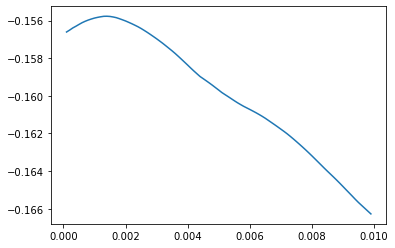

In [22]:
#For lasso regression, iterate through a range of alpha values and chose the value with the least error
alpha=[]
error=[]

for i in range(1,100):
    alpha.append(i/10000)
    lml=Lasso(alpha=(i/10000))
    error.append(np.mean(cross_val_score(lml,X_train, y_train, scoring='neg_mean_absolute_error',cv=3)))

plt.plot(alpha,error)
err=tuple(zip(alpha,error))
df_err=pd.DataFrame(err,columns=['alpha','error'])
df_err[df_err.error==max(df_err.error)]

In [23]:
#Try several different models. Due to the sparse nature of this data, we use normalized regresion techniques and tree based techniques

#Keep track of the score for each model
cv_scores_array=[]
cv_model_array=['Linear', 'Lasso', 'Random Forest', 'XGB', 'SVR', 'LGBM', 'Catboost']


#Linear regression
ln=LinearRegression()
ln.fit(X_train,y_train)
linear_score=np.average(cross_val_score(ln,X_train,y_train,scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(linear_score)


#For our final lasso model we chose the alpha that has the least error
lml=Lasso(alpha=.0014, random_state=1)
lml.fit(X_train,y_train)
lasso_score=np.average(cross_val_score(lml, X_train, y_train, scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(lasso_score)


#For Random forest use grid search to perform some hyperperameter tuning on rf model
rf = RandomForestRegressor(random_state=1)
parameters={'n_estimators':range(10,300,10), 'criterion':('squared_error','absolute_error'),'max_features':('auto','sqrt','log2')}
gs_rf=GridSearchCV(rf,parameters,scoring='neg_root_mean_squared_error', cv=3)
gs_rf.fit(X_train, y_train)
optimized_rf_score=gs_rf.best_score_
cv_scores_array.append(optimized_rf_score)


#We now try an XGBoost model
xgb=XGBRegressor(random_state=1)
params={'n_estimators': [50, 100, 500, 1000], 'max_depth':[3,4,5], 'learning_rate': [0.01,0.5,0.8]}
gs_xgb=GridSearchCV(xgb, params, cv=3, scoring='neg_root_mean_squared_error')
gs_xgb.fit(X_train, y_train)
optimized_xgb_score=gs_xgb.best_score_
cv_scores_array.append(optimized_xgb_score)


#SVR
svr=make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))
svr_score=np.average(cross_val_score(svr,X_train, y_train, scoring='neg_root_mean_squared_error',cv=3))
cv_scores_array.append(svr_score)


#LGBM
lightgbm = LGBMRegressor(random_state=1)
params={'n_estimators': [50, 100, 500, 1000,7000], 'max_depth':[3,4,5], 'learning_rate': [0.01,0.5,0.8], 'num_leaves':[4, 6, 10]}
gs_lgbm=GridSearchCV(lightgbm, params, cv=3, scoring='neg_root_mean_squared_error')
gs_lgbm.fit(X_train, y_train)
lgbm_score=gs_lgbm.best_score_
cv_scores_array.append(lgbm_score)


#Catboost 
grid={'n_estimators': [50, 100, 500, 1000,7000],'max_depth':[3,4,5], 'learning_rate':[0.05, 0.005, 0.0005],  'l2_leaf_reg':[1,3,5,9]}
catboost_model=CatBoostRegressor(verbose=False, random_state=1)
gs_catboost=catboost_model.randomized_search(grid,cv=3, X=X_train, y=y_train, verbose=False, plot=False)
catboost_score=np.mean(cv_rmse(catboost_model))
cv_scores_array.append(catboost_score)


bestTest = 1.256098122
bestIteration = 49


bestTest = 0.2430493566
bestIteration = 499


bestTest = 0.1815738013
bestIteration = 514


bestTest = 0.2026223908
bestIteration = 6999


bestTest = 0.2660591987
bestIteration = 49


bestTest = 0.1896572778
bestIteration = 95


bestTest = 1.050155916
bestIteration = 499


bestTest = 0.1832985796
bestIteration = 998


bestTest = 0.8389160128
bestIteration = 99


bestTest = 0.8505706312
bestIteration = 99

Training on fold [0/3]

bestTest = 0.1921042799
bestIteration = 803

Training on fold [1/3]

bestTest = 0.2142380743
bestIteration = 115

Training on fold [2/3]

bestTest = 0.1826087526
bestIteration = 572



Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


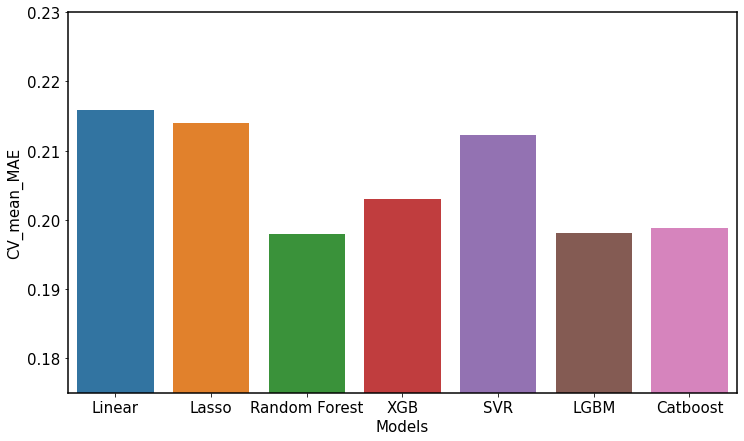

In [34]:
#Plot the scores for each model and compare to choose the best model

score_compare_dataframe=pd.DataFrame({'models':cv_model_array, 'scores':cv_scores_array})

plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
sns.barplot(score_compare_dataframe.models, np.abs(score_compare_dataframe.scores))
plt.xlabel('Models')
plt.ylabel('CV_mean_MAE')
plt.ylim([.175,0.23])
plt.show()

In [27]:
optimized_params=catboost_model.get_all_params()
optimized_params['verbose']=False

In [40]:
#We choose random forest as our final model for productionalization since it has a low error and it is simple and explainable

#we first get the optimal parameters from the grid search
optimized_params=gs_rf.best_params_

#We then make a  model with these optimized parameters
optimized_rf_model = RandomForestRegressor(**optimized_params)

optimized_rf_model.fit(np.array(X_train), np.array(y_train));

y_pred=optimized_rf_model.predict(np.array(X_test));

mae(np.expm1(y_test), np.expm1(y_pred))

0.4389876162439869

In [30]:
#pickle the model so that it can be used in a flask app
pickl={'model':optimized_rf_model}
pickle.dump(pickl,open('model_file'+".p","wb"))

In [31]:
list(X.iloc[1,:])

[3.0,
 2.0,
 1.395,
 0.13999999999999999,
 73.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [32]:
X.columns

Index(['num_bedrooms', 'num_baths', 'building_sqft', 'lot_area', 'house_age',
       'has_garage', 'has_fireplace', 'has_ocean_views', 'has_mountain_views',
       'has_hope_ranch', 'has_montecito', 'has_pool', 'has_upstairs', 'has_IV',
       'building_sqft_was_missing', 'zip_93067', 'zip_93101', 'zip_93103',
       'zip_93105', 'zip_93108', 'zip_93109', 'zip_93110', 'zip_93111',
       'zip_93117'],
      dtype='object')